# Transfer Learning

Here is to explore how good/bad of pretrained large model such as ResNet on time series data predictions.



## Load Data

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns 
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.initializers import random_uniform, constant, glorot_uniform, identity

tf.random.set_seed(1)
sns.set_style('darkgrid')


2023-07-31 12:40:23.777760: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-07-31 12:40:23.799984: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-31 12:40:24.155469: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [3]:

data_file = './data/model_ready.parquet'
df = pd.read_parquet(data_file, "pyarrow")

# sort index
df = df.sort_index()
# the frequency of the datatime index is not set. based on inspection, it is sampled hourly. here i will set the frequency to 1 hour in case in the future i may need to resample the data.
df = df.asfreq('H')

# separte names for inspection
columns = df.columns
load_names = []
wind_names = []
dewpoint_names = []
target_names = []
for col in columns:
    if 'mtlf' in col:
        load_names.append(col)
    if 'ws' in col:
        wind_names.append(col)
    if 'td' in col:
        dewpoint_names.append(col)
    if 'da_energy' in col:
        target_names.append(col)


### Data Engineering

As analyzed before, we will add the following features to dataset:
1. time features: sine and cosine pairs of day, bimonth and year

We will not detrend the target data, as we will use a skip connection to add the detrended data to the model.

In [4]:
# add time features
date_time = df.index
timestamp_s = date_time.map(pd.Timestamp.timestamp)

# the data has obvious daily pattern, bimonth pattern and annual pattern
day = 24*60*60
bimonth = (365.2425/6)*day
year = (365.2425)*day

# use cos/sin as 0 should be close to 23
df['day_sin'] = np.sin(timestamp_s * (2 * np.pi / day))
df['day_cos'] = np.cos(timestamp_s * (2 * np.pi / day))
df['bimonth_sin'] = np.sin(timestamp_s * (2 * np.pi / bimonth))
df['bimonth_cos'] = np.cos(timestamp_s * (2 * np.pi / bimonth))
df['year_sin'] = np.sin(timestamp_s * (2 * np.pi / year))
df['year_cos'] = np.cos(timestamp_s * (2 * np.pi / year))


We will only predict one target variable.

In [5]:

def target_transform(y):
    return np.log(y+50).diff()

def inverse_target_transform(dy, y_start):
    return np.exp(dy.cumsum()+np.log(y_start+50)) - 50

# we set to one target for now
target = target_names[0]
df_cpy = df.copy()

y = df_cpy[target]
df_cpy = df_cpy.drop(columns=target_names)
df_cpy = pd.concat([df_cpy, y], axis=1)

# transform target with given function
y_start = y.iloc[0]
df_cpy[target] = target_transform(y)



## Train/Val/Test split

If we do normal splitting (70%, 15%, 15%), the validation data distribution will be different from training data and testing data, which will be difficult to evaluate if the model is underfitting or just behaving well on the validation data. So we will split the data in a way that the validation data distribution is similar to the training data distribution.

We split the data into 4 parts:
- training data: 70%
- train-val data: 10%
- val data: 10%
- test data: 10%

In [6]:
train_ratio = 0.6
train_val_ratio = 0.1
val_ratio = 0.15
test_ratio = 0.15

n = len(df_cpy)
train_df = df_cpy[0:int(n*train_ratio)]
train_val_df = df_cpy[int(n*train_ratio):int(n*(train_ratio+train_val_ratio))]
val_df = df_cpy[int(n*(train_ratio+train_val_ratio)):int(n*(train_ratio+train_val_ratio+val_ratio))]
test_df = df_cpy[int(n*(train_ratio+train_val_ratio+val_ratio)):]

n_features = len(df_cpy.columns)

# drop the first row of train data as it is NAN due to difference detrending
train_df = train_df.iloc[1:]

<Axes: xlabel='interval_ending_dt_utc'>

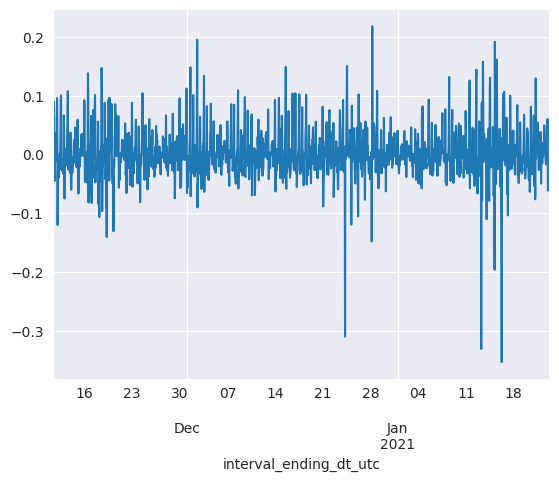

In [7]:
train_val_df[target].plot()

(4.725722835223475e-05, 0.06560733362116213)

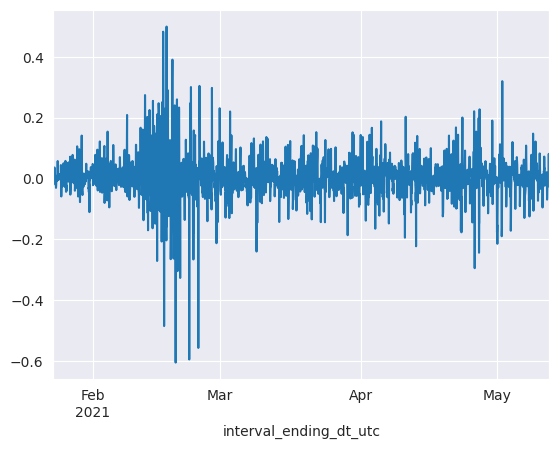

In [8]:
val_df[target].plot()
val_df[target].mean(), val_df[target].std()

(9.134646921215946e-05, 0.04670650460842325)

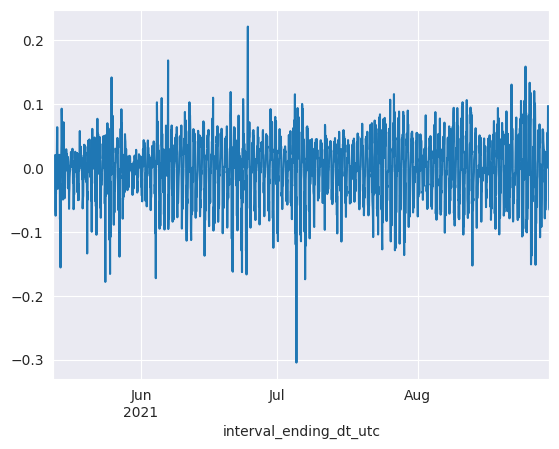

In [9]:
test_df[target].plot()
test_df[target].mean(), test_df[target].std()

## Normalize Data


We see that the data distribution is mismatched

In [10]:
train_mean = train_df.mean()
train_std = train_df.std()

train_df = (train_df - train_mean) / train_std
train_val_df = (train_val_df - train_mean) / train_std
val_df = (val_df - train_mean) / train_std
test_df = (test_df - train_mean) / train_std

print(train_df[target].mean(), train_df[target].std())
print(train_val_df[target].mean(), train_val_df[target].std())
print(val_df[target].mean(), val_df[target].std())
print(test_df[target].mean(), test_df[target].std())

-5.034449459098547e-18 1.0
0.0008927586621849807 1.1231623387831369
0.0015926960945987828 1.8858722362203488
0.0028600342207582593 1.3425709509936785


## Dataset

In [11]:
class WindowGenerator():
  def __init__(self, input_width, label_width, shift, batch_size=32, seed=1,
               train_df=train_df, train_val_df = train_val_df, val_df=val_df, test_df=test_df,
               label_columns=None):
    # Store the raw data.
    self.train_df = train_df
    self.train_val_df = train_val_df
    self.val_df = val_df
    self.test_df = test_df
    self.batch_size = batch_size
    self.seed = seed
    
    # Work out the label column indices.
    self.label_columns = label_columns
    if label_columns is not None:
      self.label_columns_indices = {name: i for i, name in
                                    enumerate(label_columns)}
    self.column_indices = {name: i for i, name in
                           enumerate(train_df.columns)}

    # Work out the window parameters.
    self.input_width = input_width
    self.label_width = label_width
    self.shift = shift

    self.total_window_size = input_width + shift

    self.input_slice = slice(0, input_width)
    self.input_indices = np.arange(self.total_window_size)[self.input_slice]

    self.label_start = self.total_window_size - self.label_width
    self.labels_slice = slice(self.label_start, None)
    self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

  # split window method
  def split_window(self, features):
    inputs = features[:, self.input_slice, :]
    labels = features[:, self.labels_slice, :]
    if self.label_columns is not None:
      labels = tf.stack(
          [labels[:, :, self.column_indices[name]] for name in self.label_columns],
          axis=-1)

    # Slicing doesn't preserve static shape information, so set the shapes
    # manually. This way the `tf.data.Datasets` are easier to inspect.
    inputs.set_shape([None, self.input_width, None])
    labels.set_shape([None, self.label_width, None])

    return inputs, labels

  def __repr__(self):
    return '\n'.join([
        f'Total window size: {self.total_window_size}',
        f'Input indices: {self.input_indices}',
        f'Label indices: {self.label_indices}',
        f'Label column name(s): {self.label_columns}'])

  def plot(self, model=None, plot_col=None, max_subplots=3):
    inputs, labels = self.example
    plt.figure(figsize=(12, 8))
    plot_col_index = self.column_indices[plot_col]
    max_n = min(max_subplots, len(inputs))
    for n in range(max_n):
      plt.subplot(max_n, 1, n+1)
      plt.ylabel(f'{plot_col} [normed]')
      plt.plot(self.input_indices, inputs[n, :, plot_col_index],
              label='Inputs', marker='.', zorder=-10)

      if self.label_columns:
        label_col_index = self.label_columns_indices.get(plot_col, None)
      else:
        label_col_index = plot_col_index

      if label_col_index is None:
        continue

      plt.scatter(self.label_indices, labels[n, :, label_col_index],
                  edgecolors='k', label='Labels', c='#2ca02c', s=64)
      if model is not None:
        predictions = model(inputs)
        plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                    marker='X', edgecolors='k', label='Predictions',
                    c='#ff7f0e', s=64)

      if n == 0:
        plt.legend()

    plt.xlabel('Time [h]')
    
  # make data set method
  def make_dataset(self, data):
    data = np.array(data, dtype=np.float32)
    ds = tf.keras.utils.timeseries_dataset_from_array(
        data=data,
        targets=None,
        sequence_length=self.total_window_size,
        sequence_stride=1,
        shuffle=True,
        seed = self.seed,
        batch_size=self.batch_size,)

    ds = ds.map(self.split_window)

    return ds

  @property
  def train(self):
    return self.make_dataset(self.train_df)
  
  @property
  def train_val(self):
    return self.make_dataset(self.train_val_df)
  
  @property
  def val(self):
    return self.make_dataset(self.val_df)

  @property
  def test(self):
    return self.make_dataset(self.test_df)

  @property
  def example(self):
    """Get and cache an example batch of `inputs, labels` for plotting."""
    result = getattr(self, '_example', None)
    if result is None:
      # No example batch was found, so get one from the `.train` dataset
      result = next(iter(self.train))
      # And cache it for next time
      self._example = result
    return result

Total window size: 12
Input indices: [0 1 2 3 4 5 6 7]
Label indices: [ 8  9 10 11]
Label column name(s): ['da_energy_aeci_lmpexpost_ac']


2023-07-31 12:40:26.625197: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-07-31 12:40:26.638687: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-07-31 12:40:26.638775: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

All shapes are: (batch, time, features)
Window shape: (3, 12, 45)
Inputs shape: (3, 8, 45)
Labels shape: (3, 4, 1)


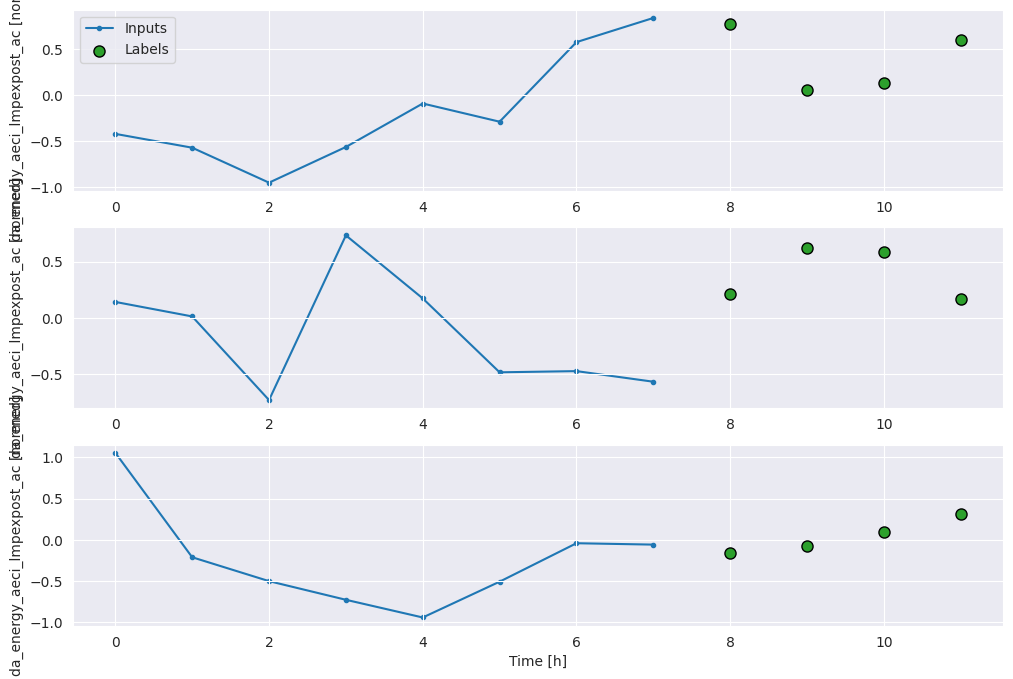

In [12]:
# example: use previous 8 steps to predict next 4 steps
input_width = 8
label_width = 4
shift = 4
example_window = WindowGenerator(
    input_width=input_width, 
    label_width=label_width, 
    shift=shift,
    label_columns=[target])

print(example_window)
batch_window = tf.stack([np.array(train_df[:example_window.total_window_size]),
                           np.array(train_df[100:100+example_window.total_window_size]),
                           np.array(train_df[200:200+example_window.total_window_size])])
batch_inputs, batch_labels = example_window.split_window(batch_window)
print('All shapes are: (batch, time, features)')
print(f'Window shape: {batch_window.shape}')
print(f'Inputs shape: {batch_inputs.shape}')
print(f'Labels shape: {batch_labels.shape}')

# plot some training data
example_window.plot(plot_col=target)

## Training Functions


In [13]:
def compile_and_fit(model, window, MAX_EPOCHS=50, lr = 1e-04, patience=2):
  #early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
  #                                                  patience=patience,
  #                                                  mode='min')

  model.compile(loss=tf.keras.losses.MeanSquaredError(),
                optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
                metrics=[tf.keras.metrics.MeanAbsoluteError()])

  history = model.fit(window.train, epochs=MAX_EPOCHS,
                      validation_data=window.train_val
                      #callbacks=[early_stopping]
                      )
  return history

## Baseline

In [14]:
n_lags = 24
n_outs = 1
shift = 1
window = WindowGenerator(
    input_width=n_lags, 
    label_width=n_outs, 
    shift=shift,
    label_columns=[target])

train_val_performance = {}
val_performance = {}
test_performance = {}

In [15]:
class Baseline(tf.keras.Model):
    def __init__(self, label_index=None):
        super().__init__()
        self.label_index = label_index
        
    def call(self, inputs):
        if self.label_index is None:
            return inputs
        result = inputs[:, :, self.label_index]
        return result[:, :, tf.newaxis]

baseline = Baseline(label_index=0)

baseline.compile(loss=tf.keras.losses.MeanSquaredError(),
                 metrics=[tf.keras.metrics.MeanAbsoluteError()])


train_val_performance['Baseline'] = baseline.evaluate(window.train_val, verbose=2)
val_performance['Baseline'] = baseline.evaluate(window.val, verbose=2)   
test_performance['Baseline'] = baseline.evaluate(window.test, verbose=2)

54/54 - 0s - loss: 1.5961 - mean_absolute_error: 0.9131 - 113ms/epoch - 2ms/step


2023-07-31 12:40:27.847287: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_8' with dtype int32 and shape [1725]
	 [[{{node Placeholder/_8}}]]
2023-07-31 12:40:27.847468: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype float and shape [1749,45]
	 [[{{node Placeholder/_0}}]]
2023-07-31 12:40:27.981105: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype float and shape [2625

82/82 - 0s - loss: 4.2901 - mean_absolute_error: 1.4122 - 74ms/epoch - 907us/step
82/82 - 0s - loss: 3.8307 - mean_absolute_error: 1.5129 - 98ms/epoch - 1ms/step


2023-07-31 12:40:28.074182: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_8' with dtype int32 and shape [2601]
	 [[{{node Placeholder/_8}}]]
2023-07-31 12:40:28.074364: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype float and shape [2625,45]
	 [[{{node Placeholder/_0}}]]


## Naive LSTM


In [16]:
lstm = tf.keras.Sequential([
    tf.keras.layers.LSTM(units=32, return_sequences=False),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(units=1),
])

In [18]:
input_shape=(32, n_lags, n_features)
lstm.build(input_shape)
lstm.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (32, 32)                  9984      
                                                                 
 dropout (Dropout)           (32, 32)                  0         
                                                                 
 dense (Dense)               (32, 1)                   33        
                                                                 
Total params: 10,017
Trainable params: 10,017
Non-trainable params: 0
_________________________________________________________________


Epoch 1/20


2023-07-31 12:42:09.959192: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype float and shape [10497,45]
	 [[{{node Placeholder/_0}}]]
2023-07-31 12:42:09.959371: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_13' with dtype int32
	 [[{{node Placeholder/_13}}]]
2023-07-31 12:42:10.054119: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype in

324/328 [============================>.] - ETA: 0s - loss: 0.8535 - mean_absolute_error: 0.6131

2023-07-31 12:42:13.685009: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype float and shape [1749,45]
	 [[{{node Placeholder/_0}}]]
2023-07-31 12:42:13.685534: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype float and shape [1749,45]
	 [[{{node Placeholder/_0}}]]
2023-07-31 12:42:13.767250: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_d

328/328 [==============================] - 4s 7ms/step - loss: 0.8515 - mean_absolute_error: 0.6123 - val_loss: 1.1014 - val_mean_absolute_error: 0.6770
Epoch 2/20
328/328 [==============================] - 3s 9ms/step - loss: 0.7177 - mean_absolute_error: 0.5465 - val_loss: 1.0360 - val_mean_absolute_error: 0.6497
Epoch 3/20
328/328 [==============================] - 2s 7ms/step - loss: 0.6589 - mean_absolute_error: 0.5198 - val_loss: 0.9731 - val_mean_absolute_error: 0.6157
Epoch 4/20
328/328 [==============================] - 3s 8ms/step - loss: 0.6165 - mean_absolute_error: 0.5025 - val_loss: 0.9372 - val_mean_absolute_error: 0.6068
Epoch 5/20
328/328 [==============================] - 3s 8ms/step - loss: 0.5861 - mean_absolute_error: 0.4906 - val_loss: 0.9183 - val_mean_absolute_error: 0.6002
Epoch 6/20
328/328 [==============================] - 3s 9ms/step - loss: 0.5598 - mean_absolute_error: 0.4778 - val_loss: 0.9201 - val_mean_absolute_error: 0.5979
Epoch 7/20
328/328 [=======

2023-07-31 12:43:06.405701: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_8' with dtype int32 and shape [1725]
	 [[{{node Placeholder/_8}}]]
2023-07-31 12:43:06.405908: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype float and shape [1749,45]
	 [[{{node Placeholder/_0}}]]
2023-07-31 12:43:06.568339: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype float and shape [2625

82/82 - 0s - loss: 3.2354 - mean_absolute_error: 1.0336 - 169ms/epoch - 2ms/step
82/82 - 0s - loss: 0.7395 - mean_absolute_error: 0.5963 - 178ms/epoch - 2ms/step


2023-07-31 12:43:06.769434: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_8' with dtype int32 and shape [2601]
	 [[{{node Placeholder/_8}}]]
2023-07-31 12:43:06.769619: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype float and shape [2625,45]
	 [[{{node Placeholder/_0}}]]


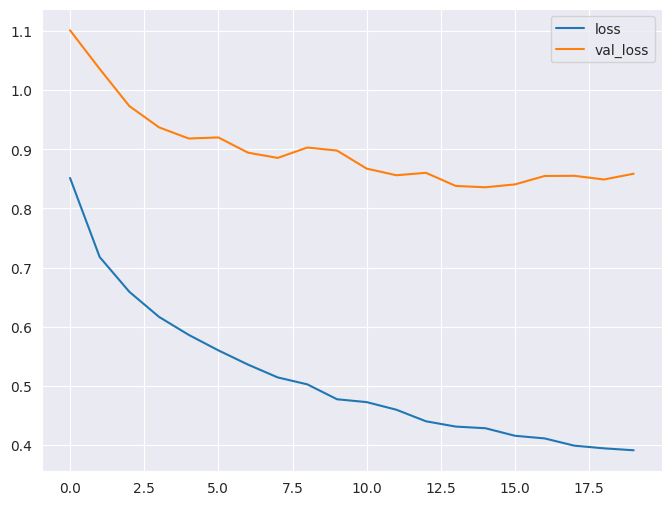

In [19]:
history = compile_and_fit(lstm, window, MAX_EPOCHS=20, lr=1e-03)
train_val_performance['lstm'] = lstm.evaluate(window.train_val, verbose=2)
val_performance['lstm'] = lstm.evaluate(window.val, verbose=2)
test_performance['lstm'] = lstm.evaluate(window.test, verbose=2)

# plot learning curves
plt.figure(figsize=(8, 6))
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend()

## Conv1D + Skip Connection

In [ ]:
def conv1d_net(input_shape, n_outs, initializer=glorot_uniform, seed=0):
    
    X_input = tf.keras.Input(input_shape)
    
    X = tf.keras.layers.Conv1D(filters=3, kernel_size=(1,), strides=1, padding='valid', kernel_initializer=initializer(seed))(X_input)
    X = tf.keras.layers.BatchNormalization()(X, training=True)
    X = tf.keras.layers.Activation('relu')(X)
    
    X = tf.keras.layers.Conv1D(filters=32, kernel_size=(7,), strides=1, padding='valid', kernel_initializer=initializer(seed))(X)
    X = tf.keras.layers.BatchNormalization()(X, training=True)
    X = tf.keras.layers.Activation('relu')(X)
    X = tf.keras.layers.MaxPool1D(pool_size=3, strides=2)(X)
    # shape of X_shortcut is (None, 8, 32)
    X_shortcut = X   
    
    # a conv1d block
    X = tf.keras.layers.Conv1D(filters=32, kernel_size=(1,), strides=1, padding='valid', kernel_initializer=initializer(seed))(X)
    X = tf.keras.layers.BatchNormalization()(X, training=True)
    X = tf.keras.layers.Activation('relu')(X)
    
    X = tf.keras.layers.Conv1D(filters=32, kernel_size=(3,), strides=1, padding='same', kernel_initializer=initializer(seed))(X)
    X = tf.keras.layers.BatchNormalization()(X, training=True)
    X = tf.keras.layers.Activation('relu')(X)
    
    X = tf.keras.layers.Conv1D(filters=128, kernel_size=(1,), strides=1, padding='valid', kernel_initializer=initializer(seed))(X)
    X = tf.keras.layers.BatchNormalization()(X, training=True)
    
    # conv for shortcut
    X_shortcut = tf.keras.layers.Conv1D(filters=128, kernel_size=(1,), strides=1, padding='valid', kernel_initializer=initializer(seed))(X_shortcut)
    X_shortcut = tf.keras.layers.BatchNormalization()(X_shortcut, training=True)
    
    # add a skip connection
    X = tf.keras.layers.Add()([X, X_shortcut])
    X = tf.keras.layers.Activation('relu')(X)
    
    # add a fully conenction network
    X = tf.keras.layers.Flatten()(X)
    #X = tf.keras.layers.Dense(32, activation='relu')(X)
    X = tf.keras.layers.Dense(n_outs)(X)
    #X = tf.keras.layers.Activation('relu')(X)

    # compile model
    model = tf.keras.Model(
        inputs = X_input, 
        outputs = X, 
        name = 'conv1d_net')

    return model
    
    

In [ ]:
conv1d = conv1d_net(input_shape=(n_lags, n_features), n_outs=1)
conv1d.summary()

Model: "conv1d_net"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 24, 45)]     0           []                               
                                                                                                  
 conv1d (Conv1D)                (None, 24, 3)        138         ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 24, 3)       12          ['conv1d[0][0]']                 
 alization)                                                                                       
                                                                                                  
 activation (Activation)        (None, 24, 3)        0           ['batch_normalization[0]

In [ ]:
history = compile_and_fit(conv1d, window, MAX_EPOCHS=50)

train_val_performance['Conv1d'] = conv1d.evaluate(window.train_val, verbose=2)
val_performance['Conv1d'] = conv1d.evaluate(window.val, verbose=2)
test_performance['Conv1d'] = conv1d.evaluate(window.test, verbose=2)

# plot learning curves
plt.figure(figsize=(8, 6))
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend()


'\nhistory = compile_and_fit(conv1d, window, MAX_EPOCHS=50)\n\nprint("==================================================")\ntrain_val_performance[\'Conv1d\'] = conv1d.evaluate(window.train_val, verbose=2)\nval_performance[\'Conv1d\'] = conv1d.evaluate(window.val, verbose=2)\ntest_performance[\'Conv1d\'] = conv1d.evaluate(window.test, verbose=2)\n\n# plot learning curves\nplt.figure(figsize=(8, 6))\nplt.plot(history.history[\'loss\'], label=\'loss\')\nplt.plot(history.history[\'val_loss\'], label=\'val_loss\')\nplt.legend()\n'

In [ ]:
# get the weights from the trained model

for layer in conv1d.layers:
    weights = layer.get_weights()
    if len(weights)==2:
        w, b = weights
        print(layer.name, w.shape, b.shape)
    elif len(weights)==1:
        w = weights[0]
        print(layer.name, w.shape)

conv1d (1, 45, 3) (3,)
conv1d_1 (7, 3, 32) (32,)
conv1d_2 (1, 32, 32) (32,)
conv1d_3 (3, 32, 32) (32,)
conv1d_4 (1, 32, 128) (128,)
conv1d_5 (1, 32, 128) (128,)
dense (1024, 1) (1,)


## Conv1D + LSTM 

In [ ]:
lstm_lags = tf.keras.Sequential([
    tf.keras.layers.Conv1D(filters=16, kernel_size=7, padding='valid', strides=3, activation='relu', input_shape=(n_lags, n_features)),
    tf.keras.layers.LSTM(units=32, return_sequences=False),
    #tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(units=n_outs), #activation='relu'),
])

# check model summary
input_shape=(32, n_lags, n_features)
lstm_lags.build(input_shape)
lstm_lags.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_12 (Conv1D)          (None, 6, 16)             5056      
                                                                 
 lstm_6 (LSTM)               (None, 32)                6272      
                                                                 
 dense_7 (Dense)             (None, 1)                 33        
                                                                 
Total params: 11,361
Trainable params: 11,361
Non-trainable params: 0
_________________________________________________________________


2023-07-31 10:29:45.577137: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-07-31 10:29:45.577990: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-07-31 10:29:45.578540: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/15


2023-07-31 10:29:48.428402: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype float and shape [10497,45]
	 [[{{node Placeholder/_0}}]]
2023-07-31 10:29:48.428592: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_13' with dtype int32
	 [[{{node Placeholder/_13}}]]
2023-07-31 10:29:48.679699: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype in

328/328 [==============================] - ETA: 0s - loss: 0.7501 - mean_absolute_error: 0.5537

2023-07-31 10:29:51.498582: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_14' with dtype int32
	 [[{{node Placeholder/_14}}]]
2023-07-31 10:29:51.499277: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_8' with dtype int32 and shape [1725]
	 [[{{node Placeholder/_8}}]]
2023-07-31 10:29:51.597645: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32


328/328 [==============================] - 3s 7ms/step - loss: 0.7501 - mean_absolute_error: 0.5537 - val_loss: 1.0115 - val_mean_absolute_error: 0.6436
Epoch 2/15
328/328 [==============================] - 2s 7ms/step - loss: 0.6103 - mean_absolute_error: 0.4940 - val_loss: 0.9692 - val_mean_absolute_error: 0.6360
Epoch 3/15
328/328 [==============================] - 2s 7ms/step - loss: 0.5598 - mean_absolute_error: 0.4699 - val_loss: 0.9389 - val_mean_absolute_error: 0.6192
Epoch 4/15
328/328 [==============================] - 2s 5ms/step - loss: 0.5263 - mean_absolute_error: 0.4555 - val_loss: 0.9171 - val_mean_absolute_error: 0.6064
Epoch 5/15
328/328 [==============================] - 3s 8ms/step - loss: 0.4972 - mean_absolute_error: 0.4437 - val_loss: 0.8973 - val_mean_absolute_error: 0.5962
Epoch 6/15
328/328 [==============================] - 3s 8ms/step - loss: 0.4764 - mean_absolute_error: 0.4362 - val_loss: 0.8641 - val_mean_absolute_error: 0.5815
Epoch 7/15
328/328 [=======

2023-07-31 10:30:27.162440: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_14' with dtype int32
	 [[{{node Placeholder/_14}}]]
2023-07-31 10:30:27.162634: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_13' with dtype int32
	 [[{{node Placeholder/_13}}]]
2023-07-31 10:30:27.362627: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_14' with dtype int32
	 [[{{node Placeholder/_14}}]]
2023-07-31 10:30

82/82 - 0s - loss: 2.5174 - mean_absolute_error: 0.9289 - 128ms/epoch - 2ms/step
82/82 - 0s - loss: 0.6666 - mean_absolute_error: 0.5716 - 120ms/epoch - 1ms/step


2023-07-31 10:30:27.513389: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype float and shape [2625,45]
	 [[{{node Placeholder/_0}}]]
2023-07-31 10:30:27.513577: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_13' with dtype int32
	 [[{{node Placeholder/_13}}]]


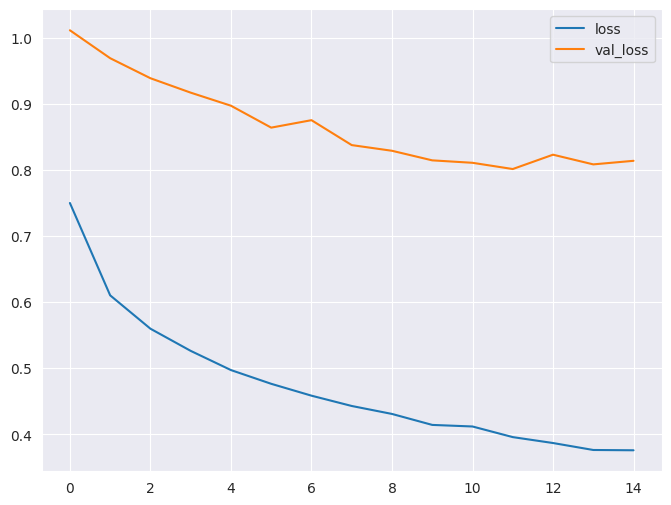

In [ ]:
history = compile_and_fit(lstm_lags, window, MAX_EPOCHS=15, lr=1e-03)

print("==================================================")
train_val_performance['Conv1d'] = lstm_lags.evaluate(window.train_val, verbose=2)
val_performance['Conv1d'] = lstm_lags.evaluate(window.val, verbose=2)
test_performance['Conv1d'] = lstm_lags.evaluate(window.test, verbose=2)

# plot learning curves
plt.figure(figsize=(8, 6))
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend()

## Seq2Seq

Here we explore a slightly more complex structure using sequence-to-sequence models, which could be easily extended for multiple output predictions.

- Conv1D
- LSTM
- LSTM
- Dense

This model is similar to a voice triggering system, where the input is a sequence of audio frames and the output is a sequence of binary values indicating whether the trigger word is present in the audio clip.

In [ ]:
def seq(input_shape, n_outs):
    X_in = tf.keras.layers.Input(shape=input_shape)
    
    # conv1d layer
    X = tf.keras.layers.Conv1D(filters=128, kernel_size=7, strides=3, padding='valid')(X_in)
    X = tf.keras.layers.BatchNormalization()(X) # not need to add training=True as we use model.fit() and model.evaluate()
    X = tf.keras.layers.Activation('relu')(X)
    X = tf.keras.layers.Dropout(0.8)(X)
    
    # first LSTM layer
    X = tf.keras.layers.LSTM(units=128, return_sequences=True)(X)
    X = tf.keras.layers.Dropout(0.8)(X)
    X = tf.keras.layers.BatchNormalization()(X)
    
    # second LSTM layer
    X = tf.keras.layers.LSTM(units=128, return_sequences=True)(X)
    X = tf.keras.layers.Dropout(0.8)(X)
    X = tf.keras.layers.BatchNormalization()(X)
    X = tf.keras.layers.Dropout(0.8)(X)
    
    # time distributed layer for many outputs
    # X = tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(1))(X)
    
    # output layer
    X = tf.keras.layers.Flatten()(X)
    X = tf.keras.layers.Dense(n_outs)(X)
    
    # MODEL
    model = tf.keras.models.Model(inputs=X_in, outputs=X, name='many2one')
    
    return model
    
    

In [ ]:
many2one = seq(input_shape=(n_lags, n_features), n_outs=1)
many2one.summary()

Model: "many2one"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 24, 45)]          0         
                                                                 
 conv1d_19 (Conv1D)          (None, 6, 128)            40448     
                                                                 
 batch_normalization_23 (Bat  (None, 6, 128)           512       
 chNormalization)                                                
                                                                 
 activation_11 (Activation)  (None, 6, 128)            0         
                                                                 
 dropout_25 (Dropout)        (None, 6, 128)            0         
                                                                 
 lstm_18 (LSTM)              (None, 6, 128)            131584    
                                                          

2023-07-31 12:04:48.608551: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-07-31 12:04:48.609445: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-07-31 12:04:48.609976: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/30


2023-07-31 12:04:51.559414: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype float and shape [10497,45]
	 [[{{node Placeholder/_0}}]]
2023-07-31 12:04:51.559605: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype float and shape [10497,45]
	 [[{{node Placeholder/_0}}]]
2023-07-31 12:04:51.657119: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split

325/328 [============================>.] - ETA: 0s - loss: 4.9737 - mean_absolute_error: 1.6600

2023-07-31 12:04:58.751202: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_14' with dtype int32
	 [[{{node Placeholder/_14}}]]
2023-07-31 12:04:58.751795: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_13' with dtype int32
	 [[{{node Placeholder/_13}}]]
2023-07-31 12:04:58.841558: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node grad

328/328 [==============================] - 8s 17ms/step - loss: 4.9531 - mean_absolute_error: 1.6555 - val_loss: 1.2457 - val_mean_absolute_error: 0.7272
Epoch 2/30
328/328 [==============================] - 4s 12ms/step - loss: 1.3380 - mean_absolute_error: 0.8359 - val_loss: 1.2511 - val_mean_absolute_error: 0.7296
Epoch 3/30
328/328 [==============================] - 4s 13ms/step - loss: 1.0249 - mean_absolute_error: 0.7009 - val_loss: 1.2545 - val_mean_absolute_error: 0.7348
Epoch 4/30
328/328 [==============================] - 5s 16ms/step - loss: 1.0175 - mean_absolute_error: 0.6935 - val_loss: 1.2523 - val_mean_absolute_error: 0.7292
Epoch 5/30
328/328 [==============================] - 5s 14ms/step - loss: 1.0156 - mean_absolute_error: 0.6939 - val_loss: 1.2591 - val_mean_absolute_error: 0.7437
Epoch 6/30
328/328 [==============================] - 6s 17ms/step - loss: 1.0144 - mean_absolute_error: 0.6931 - val_loss: 1.2520 - val_mean_absolute_error: 0.7373
Epoch 7/30
328/328 [=

2023-07-31 12:07:31.732837: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_8' with dtype int32 and shape [1725]
	 [[{{node Placeholder/_8}}]]
2023-07-31 12:07:31.733029: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_8' with dtype int32 and shape [1725]
	 [[{{node Placeholder/_8}}]]
2023-07-31 12:07:31.900104: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_8' with dtype int32 and shape [2601]
	

82/82 - 0s - loss: 2.9766 - mean_absolute_error: 1.0214 - 135ms/epoch - 2ms/step


2023-07-31 12:07:32.063771: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_8' with dtype int32 and shape [2601]
	 [[{{node Placeholder/_8}}]]
2023-07-31 12:07:32.063967: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_8' with dtype int32 and shape [2601]
	 [[{{node Placeholder/_8}}]]


82/82 - 0s - loss: 0.7711 - mean_absolute_error: 0.6154 - 251ms/epoch - 3ms/step


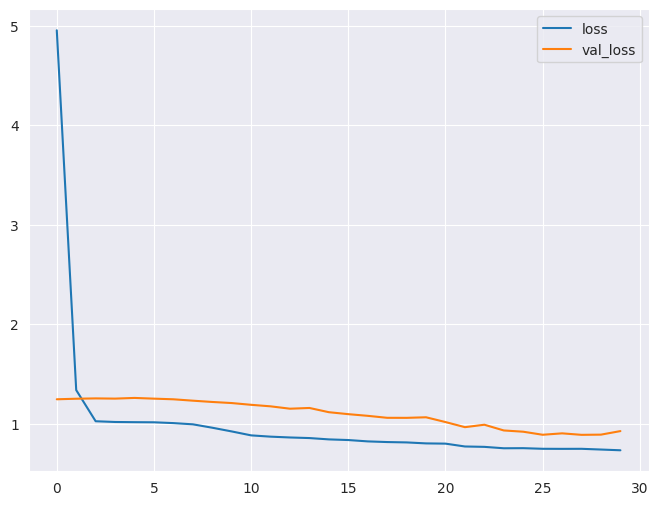

In [ ]:
history = compile_and_fit(many2one, window, MAX_EPOCHS=30, lr=1e-03)

print("==================================================")
train_val_performance['many2one'] = many2one.evaluate(window.train_val, verbose=2)
val_performance['many2one'] = many2one.evaluate(window.val, verbose=2)
test_performance['many2one'] = many2one.evaluate(window.test, verbose=2)

# plot learning curves
plt.figure(figsize=(8, 6))
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend()